<div align="right" style="text-align: right;"><i>Peter Norvig<br>April 2020</i></div>

# Jotto and Wordle: Word Guessing Games

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a word game in which a **guesser** tries to guess a secret **target** word, which is chosen from a **word list** of allowable words, in as few guesses as possible. Each guess must be one of the allowable words, and the **reply** to each guess is the number of letters in common between the guess word and the target word, regardless of the positions of the letters.   

Here is an example Jotto game, where I show the guesses, the replies, the number of remaining targets that are **consistent** with all the replies seen so far, and finally the letters that matched (the matches are an aid to you, the reader; they are not known to the guesser). In this game, the guesser gets to the target word, "wonky", in 7 guesses. 

    Guess 1: "stoma" Reply: 1 right; Consistent targets: 1118    (Matched: "o")
    Guess 2: "bairn" Reply: 1 right; Consistent targets: 441     (Matched: "n")
    Guess 3: "swipe" Reply: 1 right; Consistent targets: 197     (Matched: "w")
    Guess 4: "lurks" Reply: 1 right; Consistent targets: 87      (Matched: "k")
    Guess 5: "rowdy" Reply: 3 right; Consistent targets: 14      (Matched: "owy")
    Guess 6: "roved" Reply: 1 right; Consistent targets: 2       (Matched: "o")
    Guess 7: "wonky" Reply: 5 right; Consistent targets: 1       (Matched: "wonky")


There are several variants of the game; here are five key questions and my answers:

- Q: How many letters can each word be? <br>A: **Only five-letter words are allowed**.
- Q: Does a guess have to be a word in the word list? <br>A: **Yes.**
- Q: What is the reply for a word that has the same letter twice, like the "s" in "stars"? <br>A: **Only words with no repeated letters are allowed in the word list**.
- Q: What if the reply is "5", but the guess is not the target?<br>A: **No two words in the word list are allowed to have the same set of five letters**.<br>For example, only one of the anagrams apers/pares/parse/pears/reaps/spare/spear is allowed.
- Q: Who chooses the target word? <br>A: **Random chance**. Jotto is sometimes a two-person game where the chooser is an adversary, but not here.

# Preliminaries

First off, some Python basics: Import some modules and define the basic types `Word`, `Score`, and `Reply`:

In [1]:
from typing      import List, Tuple, Dict, Union, Counter, Callable
from dataclasses import dataclass
from statistics  import mean, stdev
from collections import defaultdict
from math        import log
import random
import matplotlib.pyplot as plt

Word  = str # A word is a lower-case string of five distinct characters
Score = int # A score is the number of guesses it took to get the target
Reply = int # A reply is the number of letters in common between guess and target words

We can make a Jotto word list by starting with a list of words, discarding the ones that don't have 5 distinct letters, putting the rest into a dict keyed by the set of letters, and then keeping only one word for each set of letters:

In [2]:
def allowable(words) -> List[Word]:
    """Build a list of allowable Jotto words from an iterable of words."""
    dic = {frozenset(w): w for w in words if len(w) == 5 == len(set(w))}
    return list(dic.values())

The file [sgb-words.txt](sgb-words.txt) (from the [Stanford GraphBase project](https://www-cs-faculty.stanford.edu/~knuth/sgb.html)) has a nice list of five-letter words.

In [3]:
! [ -e sgb-words.txt ] || curl -O https://norvig.com/ngrams/sgb-words.txt
    
sgb_words = open('sgb-words.txt').read().split()
wordlist  = allowable(sgb_words)

len(sgb_words), len(wordlist)

(5756, 2845)

We see there are 2,845 allowable target words out of the 5,756 words in [sgb-words.txt](sgb-words.txt).

# Playing a Game

The function `play` will play a game of Jotto and return the score (the number of guesses). The function's arguments are:
- `guesser`: a `callable` (e.g., a function) that should return the guess to make. It is passed two arguments: the reply to the previous guess, and the words that are consistent with all the guesses made so far. (If the guesser wants to keep track of all the guesses made so far, or all the words in the word list, it is welcome to do so itself. A guesser need not be a pure function; it can remember things from one call to the next.)
- `target`: The target word. If none is given, the target word is chosen at random from the wordlist.
- `wordlist`: The list of allowable words.
- `verbose`: If true, print a message for each guess.

Two corner cases: (1) If the guesser improperly guesses a non-word, the reply is -1. (2) If a poor guesser makes as many guesses as there are words in the list the game stops and the guesser gets as a score the number of words in the list (thus avoiding an infinite loop).

In [4]:
Guesser = Callable[[Reply, List[Word]], Word]

def play(guesser: Guesser, target=None, wordlist=wordlist, verbose=False) -> Score:
    """How many guesses does it take for `guesser` to guess the Jotto target word,
    which is selected by `chooser` from the words in `wordlist`?"""
    target  = target or random.choice(wordlist) # Choose a random target if none was given
    targets = wordlist # The targets that are consistent with all replies
    reply   = None     # For the first guess, there is no previous reply
    for i in range(1, len(wordlist) + 1):
        guess = guesser(reply, targets)
        reply = reply_for(guess, target) if guess in wordlist else -1
        targets = [w for w in targets if reply_for(guess, w) == reply]
        if verbose: 
            print(f'Guess {i}: "{guess}" Reply: {reply} right; Consistent targets: {len(targets)}')
        if guess == target:  
            return i
    return i
                         
def reply_for(guess, target) -> Reply: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

# Simple Guessers

Here we define two simple guessers:
- `human_guesser` asks a human for `input`.
- `random_guesser` guesses one of the remaining consistent  targets, picked at random. We show it in action:


In [5]:
def human_guesser(reply, targets) -> Word: return input(f'Reply was {reply}. Guess:')

def random_guesser(reply, targets) -> Word: return random.choice(targets)

play(random_guesser, verbose=True)

Guess 1: "henry" Reply: 1 right; Consistent targets: 1254
Guess 2: "prods" Reply: 1 right; Consistent targets: 535
Guess 3: "fovea" Reply: 1 right; Consistent targets: 229
Guess 4: "daunt" Reply: 3 right; Consistent targets: 25
Guess 5: "unmap" Reply: 3 right; Consistent targets: 4
Guess 6: "mount" Reply: 2 right; Consistent targets: 3
Guess 7: "ulnas" Reply: 2 right; Consistent targets: 1
Guess 8: "inapt" Reply: 5 right; Consistent targets: 1


8

# Evaluating Guessers

That was just one sample game; maybe there was some luck involved. To properly evaluate a guesser we can try it with every possible target word. (This is straightforward when the guesser is a program; tedious when the guesser is a human.) The function `evaluate_guesser` plays a game with every target in `wordlist` and collects the scores into a Counter. 

In [6]:
def evaluate_guesser(guesser, wordlist=wordlist) -> Counter[Score]:
    """Counter of scores for this guesser on all the targets in `wordlist`."""
    return Counter(play(guesser, target, wordlist, verbose=False)
                   for target in wordlist)

In [7]:
scores = evaluate_guesser(random_guesser)
scores

Counter({9: 346,
         6: 520,
         8: 629,
         7: 756,
         10: 143,
         5: 228,
         11: 71,
         2: 5,
         12: 28,
         4: 67,
         13: 12,
         14: 7,
         15: 5,
         3: 27,
         16: 1})

To get a better feel for these scores, the function `show` prints the mean, standard deviation, worst case number of guesses, and total number of words; followed by a display of the cumulative percentage guessed correctly for different numbers of guesses (e.g., the notation `"≤5:11%"` means that 11% of the targets were guessed in 5 or fewer guesses); followed by a histogram of scores:

In [8]:
def show(scores: Counter[int]):
    """Show a histogram and statistics for these scores."""
    bins = range(min(scores), max(scores) + 2)
    s = list(scores.elements()) # The individual scores
    scale = 100 / len(s)
    plt.hist(list(scores), weights=[scale * scores[s] for s in scores],
             align='left', rwidth=0.9, bins=bins)
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses'); plt.ylabel('% of targets')
    print(f'mean: {mean(s):.2f} ± {stdev(s):.2f} guesses, worst: {max(s)}, N: {len(s):,d}')
    def pct(g): return round(scale * sum(scores[i] for i in range(g + 1)))
    print('cumulative:', ', '.join(f'≤{g}:{pct(g)}%' for g in range(3, 11)))

mean: 7.36 ± 1.73 guesses, worst: 16, N: 2,845
cumulative: ≤3:1%, ≤4:3%, ≤5:11%, ≤6:30%, ≤7:56%, ≤8:78%, ≤9:91%, ≤10:96%


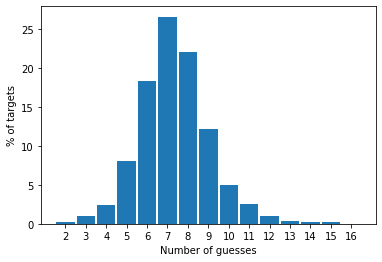

In [9]:
show(scores)

The random guesser strategy might have seemed hopelessly naive, but it is actually a pretty decent strategy. The average is a bit more than 7 guesses and about 80% of the time it will take 8 guesses or less. Can we improve on that?

#  Guessers that Partition Targets

A key idea in guessing is to reduce the number of consistent targets. We can think of a guess as **partitioning** the consistent targets into different **branches** of a tree, each branch corresponding to a different reply:

In [10]:
def partition(guess, targets) ->  Dict[Reply, List[str]]:
    """A partition of targets by the possible replies to guess: {reply: [word, ...]}."""
    branches = defaultdict(list)
    for target in targets:
        branches[reply_for(guess, target)].append(target)
    return branches

To make the output easier to see, here's a partition of just 15 targets (every 200th word in `wordlist`):

In [11]:
partition('vicar', wordlist[::200])

defaultdict(list,
            {2: ['their', 'logic', 'grime', 'crone', 'fovea'],
             3: ['pairs', 'recta', 'divas'],
             1: ['flock', 'comfy', 'thrum', 'inode'],
             0: ['sloth', 'judos'],
             5: ['vicar']})

We see that after guesssing `'vicar'`, no matter what the reply is, we will be left with no more than five consistent targets. That seems like a good thing, and suggests a strategy: **guess a word that partitions the possible targets into small branches.**

If we onjly want to know the *size* of each branch, not the list of words therein, we can use `partition_counts` rather than `partition`:

In [12]:
def partition_counts(guess, targets) -> Counter[Reply]: 
    "A Counter of the sizes of each branch of the partition of targets by guess."
    return Counter(reply_for(guess, target) for target in targets)

In [13]:
partition_counts('vicar', wordlist[::200])

Counter({2: 5, 3: 3, 1: 4, 0: 2, 5: 1})

Below are the partition counts for two possible first guesses, `ouija` and `coder`, on the complete wordlist:

In [14]:
partition_counts('ouija', wordlist)

Counter({1: 1848, 3: 65, 2: 755, 0: 175, 4: 1, 5: 1})

In [15]:
partition_counts('coder', wordlist)

Counter({2: 1014, 1: 1030, 3: 327, 0: 433, 4: 40, 5: 1})

It looks like `'coder'` is a better first guess than `'ouija'`, because `'ouija'` has a good chance of leaving you with a huge 1848-word branch, while `'coder'` is guaranteed to leave no more than 1030 in a branch, no matter what the reply.

What exactly is the metric for deciding which partition is better? What we really want to know is how many additional guesses it will take to handle each branch, but since we don't know that, we can use one of the following proxy metrics and find the best partion by:

- **Minimizing the maximum of the partition counts**. That is, we should deduce that `coder`, with its `max` partition count of 1030, is a better guess than `ouija`, with its `max` of 1848. 

- **Minimizing the expected value of the partition counts**. In probability theory the expected value or **expectation** is the weighted average of a random variable. Here it means the sum, over all branches, of the size of the branch multiplied by the probability of ending up in the branch. We are assuming that every target is equally likely, so the probability of a branch is proportional to the number of targets in it.

- **Maximizing the entropy in the partition counts**. Entropy is an information-theoretic measure that is similar to expectation, except that it weights each branch size by its base 2 logarithm (whereas expectation weights it by its actual size). Since the other two metrics are minimizing, we will minimize *negative* entropy.

In [16]:
def max_count(scores: Counter[Reply]) -> int:
    "The maximum count in a Counter of scores."
    return max(scores.values())
    
def expectation(scores: Counter[Reply]) -> float:
    "The expected value of a Counter of scores."
    scale = 1/sum(scores.values())
    def P(x): return scale * x
    return sum(P(x) * x for x in scores.values())

def neg_entropy(scores: Counter[Reply]) -> float: 
    """The negation of the entropy of a Counter of scores."""
    scale = 1/sum(scores.values())
    def P(x): return scale * x
    return sum(P(x) * log(P(x), 2) for x in scores.values())

Here are the top and bottom 4 guess words according to each of the three metrics:

In [17]:
def extreme(n, metrics=(max_count, expectation, neg_entropy), wordlist=wordlist) -> List[Word]: 
    """The top and bottom n words to guess, according to each metric."""
    for metric in metrics:
        pairs = sorted([metric(partition_counts(g, wordlist)), g] for g in wordlist)
        def num(m): return f'{round(m):4d}' if m > 0 else f'{abs(m):4.2f}'
        def fmt(pairs): return " ".join(f'{w}:{num(m)}' for m, w in pairs)
        print(f'{metric.__name__:>11}: {fmt(pairs[:n])} | {fmt(pairs[-n:])}')
        
extreme(4)

  max_count: wader:1012 cadre:1026 armed:1028 diner:1029 | quota:1548 azoic:1555 axiom:1615 ouija:1848
expectation: raved: 813 debar: 818 roved: 827 orbed: 827 | azoic:1120 axiom:1157 audio:1184 ouija:1413
neg_entropy: debar:1.95 alder:1.95 raved:1.94 dater:1.94 | juicy:1.57 axiom:1.56 audio:1.49 ouija:1.29


Which metric is best? We have the tools to answer that: we could use `evaluate_guesser` to get scores for guessers that use each of the three metrics. But that would take a long time. It takes about 5 seconds to compute the best first guess; I don't want to repeat that for every target word.

#  Guesser Trees 

I can speed up computation by precomputing and caching a **guesser tree**: a tree that has branches for every possible path the game might take, with the best guess for each situation already computed. A guesser tree is either:
- An **interior node**, which has a guess and a dict of branches, `Node(guess, {reply: subtree, ...})`, where  each subtree covers all the target words that are consistent with the corresponding reply.
- A **leaf word**, such as `'coder'`, indicating that this is the sole remaining consistent target word. Every word in the word list should appear as a leaf in exactly one place in a guesser tree.

In [18]:
@dataclass 
class Node:
    guess: Word
    branches: Dict[Reply, 'Tree']

Tree = Union[Word, Node] # A Tree is a leaf Word or an interior Node

The function `make_tree(metric, targets)` builds a tree that covers all the targets and that, at every node, guesses a word that  minimizes the `metric` applied to the `partition_counts` of the guess.

In [19]:
def make_tree(metric, targets) -> Tree:
    """Make a tree that guesses to minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: make_tree(metric, branches[reply]) 
                        for reply in sorted(branches)})

Here is a tree that covers five words by always making a guess that minimizes the maximum number in the partition counts:

In [20]:
words5 = ['purge', 'bites', 'sulky', 'patsy', 'hayed']

tree5  = make_tree(max_count, words5)

assert tree5 == Node(guess='bites', 
                     branches={1: Node(guess='purge', 
                                       branches={1: Node(guess='sulky', 
                                                         branches={1: 'hayed', 5: 'sulky'}), 
                                                 5: 'purge'}), 
                               2: 'patsy', 
                               5: 'bites'})

The tree says that the first guess is `'bites'`, and if the reply is `1` there is a complex subtree to consider (starting with the guess `'purge'`), but if the reply is `2` the target can only be `'patsy'` and of course if the reply is `5` then `'bites'` was the target.

# Turning a Tree into a Callable Guesser

Now that we've made a tree, we need to use it as a component of a guesser that `play` can call upon. A `TreeGuesser` is an object that stores a tree in the `self.root` and `self.tree` attributes, and while the game is being played, it follows branches in the tree, choosing the guess indicated at each node. This is done within the `__call__` method, because `play` expects a callable.  Note that on the first turn of a new game there is no previous turn, and hence the variable `reply` is `None`, in which case we reset `self.tree` to be the root tree. For subsequent turns, we follow the branch indicated by the reply. 

In [21]:
class TreeGuesser:
    """Given a guesser tree, use it to create a callable Guesser that can play Jotto."""
    def __init__(self, tree): self.root = self.tree = tree
        
    def __call__(self, reply, targets) -> str:
        """If reply is None, start a new game; otherwise follow the branch for the reply.
        Then return the current leaf or interior node guess."""
        self.tree = self.root if reply is None else self.tree.branches[reply]
        return self.tree if isinstance(self.tree, str) else self.tree.guess

Here we build a tree and use it to play a game:

In [22]:
tree = make_tree(max_count, wordlist)

play(TreeGuesser(tree), verbose=True)

Guess 1: "wader" Reply: 2 right; Consistent targets: 1004
Guess 2: "lawns" Reply: 1 right; Consistent targets: 339
Guess 3: "douse" Reply: 2 right; Consistent targets: 113
Guess 4: "bergs" Reply: 3 right; Consistent targets: 31
Guess 5: "treks" Reply: 4 right; Consistent targets: 11
Guess 6: "terms" Reply: 4 right; Consistent targets: 6
Guess 7: "tiers" Reply: 4 right; Consistent targets: 5
Guess 8: "crest" Reply: 4 right; Consistent targets: 4
Guess 9: "frets" Reply: 4 right; Consistent targets: 3
Guess 10: "prest" Reply: 4 right; Consistent targets: 2
Guess 11: "treys" Reply: 4 right; Consistent targets: 1
Guess 12: "verst" Reply: 5 right; Consistent targets: 1


12

# Making Inconsistent Guesses

So far,  we have always guessed one of the consistent targets. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it *is* a good strategy to guess such a word.

I will redefine `make_tree` so that it is passed both the list of consistent target words and the complete word list. It also takes a flag, `inconsistent`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only consistent targets are considered, as before. 

In [23]:
def make_tree(metric, targets, wordlist=wordlist, inconsistent=False) -> Tree:
    """Make a tree that guesses to minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        words = wordlist if (inconsistent and len(targets) > 3) else targets
        guess = min(words, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: make_tree(metric, branches[reply], wordlist, inconsistent) 
                            for reply in sorted(branches)})

Here we see that by default, `make_tree` behaves just as it did before:

In [24]:
assert make_tree(max_count, words5) == (
    Node(guess='bites', 
         branches={1: Node(guess='purge', 
                           branches={1: Node(guess='sulky', 
                                             branches={1: 'hayed', 5: 'sulky'}), 
                                     5: 'purge'}), 
                                     2: 'patsy', 5: 'bites'}))

But with `inconsistent=True`, we get a better tree:

In [25]:
tree5b = make_tree(max_count, words5, inconsistent=True)
tree5b

Node(guess='dashy', branches={0: 'purge', 1: 'bites', 2: 'sulky', 3: 'patsy', 4: 'hayed'})

This tree guesses an inconsistent word (not one of the words in `words5`) with the first guess. There is no chance that this is the target, but it sets us up so that we will always be able to guess correctly on the second guess. So the minimum, mean, and maximum number of guesses is 2.

In contrast, making only consistent guesses can take up to four guesses in the worst case (`'hayed'`), and has a mean number of guesses of 2.4:

mean: 2.40 ± 1.14 guesses, worst: 4, N: 5
cumulative: ≤3:80%, ≤4:100%, ≤5:100%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%


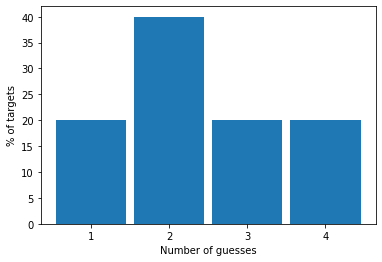

In [26]:
show(evaluate_guesser(TreeGuesser(tree5), words5))

# Comparing Metrics

Now we will compare the three metrics, with and without inconsistent targets.
The function `show_metric` makes the appropriate `TreeGuesser` and calls `evaluate_guesser` and `show` to display results:

In [27]:
def show_metric(metric, inconsistent=False, wordlist=wordlist) -> None:
    """Show statistics and histogram for a guesser that minimizes `metric` over partition counts."""
    tree = make_tree(metric, wordlist, wordlist, inconsistent)
    show(evaluate_guesser(TreeGuesser(tree), wordlist))

# Comparing Metrics with Consistent Guesses Only

mean: 7.15 ± 1.81 guesses, worst: 18, N: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:35%, ≤7:67%, ≤8:86%, ≤9:92%, ≤10:95%
CPU times: user 12.5 s, sys: 12.1 ms, total: 12.5 s
Wall time: 12.5 s


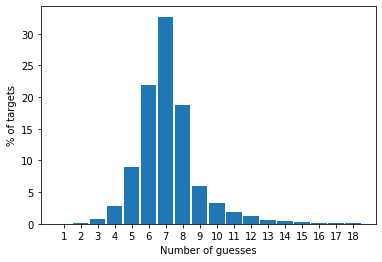

In [28]:
%time show_metric(max_count, False)

mean: 7.14 ± 1.82 guesses, worst: 17, N: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:68%, ≤8:85%, ≤9:91%, ≤10:95%
CPU times: user 12.3 s, sys: 10.7 ms, total: 12.3 s
Wall time: 12.3 s


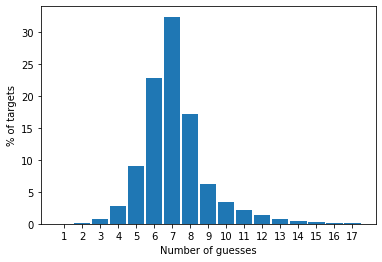

In [29]:
%time show_metric(expectation, False)

mean: 7.10 ± 1.79 guesses, worst: 19, N: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:69%, ≤8:86%, ≤9:92%, ≤10:96%
CPU times: user 12.8 s, sys: 21.5 ms, total: 12.8 s
Wall time: 12.8 s


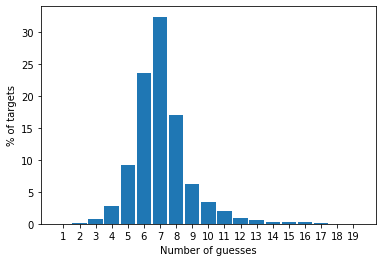

In [30]:
%time show_metric(neg_entropy, False)

# Comparing Metrics with Inconsistent Guesses Allowed

mean: 7.05 ± 0.98 guesses, worst: 10, N: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:6%, ≤6:24%, ≤7:69%, ≤8:95%, ≤9:100%, ≤10:100%
CPU times: user 34 s, sys: 33.3 ms, total: 34 s
Wall time: 34.1 s


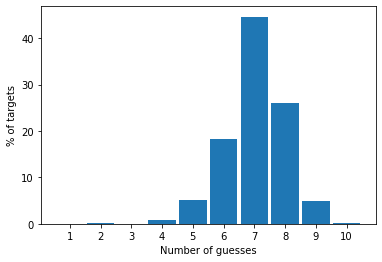

In [31]:
%time show_metric(max_count, True)

mean: 6.84 ± 0.95 guesses, worst: 10, N: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:7%, ≤6:32%, ≤7:78%, ≤8:97%, ≤9:100%, ≤10:100%
CPU times: user 34.8 s, sys: 35.2 ms, total: 34.9 s
Wall time: 34.9 s


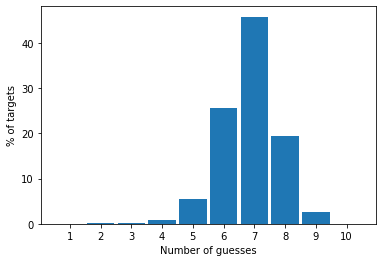

In [32]:
%time show_metric(expectation, True)

mean: 6.82 ± 1.00 guesses, worst: 10, N: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:8%, ≤6:35%, ≤7:77%, ≤8:97%, ≤9:100%, ≤10:100%
CPU times: user 35.8 s, sys: 28.5 ms, total: 35.9 s
Wall time: 35.9 s


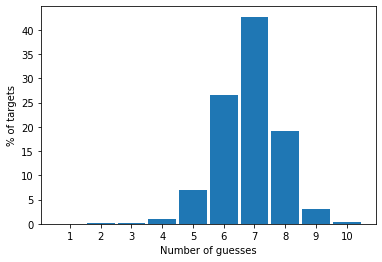

In [33]:
%time show_metric(neg_entropy, True)

# Jotto Summary

Here's a table of results:

|<br><br>Algorithm|Consistent<br><u>Only</u><br>Mean (Max)|Inconsistent<br><u>Allowed</u><br>Mean (Max)|
|--|--|--|
|baseline random guesser|7.36 (17)|  |
|minimize max_counts|7.15 (18)|7.05 (10)|
|minimize expectation|7.14 (17)|6.84 (10)|
|minimize neg_entropy|7.10 (19)|6.82 (10)|

So we started out with a mean of 7.36 and a worst score of 17 with the random guesser, and were able to improve by half a guess to a mean of 6.81 and a worst score of 10 using  minimization of negative entropy over partition counts, with inconsistent guesses allowed.

# Wordle

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a [suddenly-popular](https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html) variant of Jotto (with some Mastermind thrown in) with these differences:
- Words with repeated letters are allowed, as are anagrams.
- The reply to a guess consists of 5 trits of information, one for each position in the guess:
  - *Green* if the guess letter is in the correct spot.
  - *Yellow* if the guess letter is in the word but in the wrong spot.
  - *Miss* if the letter is not in the word in any spot.
  
Since repeated letters and anagrams are allowed, I can use all of `sgb_words` as my list of allowable Wordle words.

There seems to be an ambiguity in the rules. Assume the guess is *etude* and the target is *poems*. I think the correct reply should be that one letter *e* is *yellow* and the other is a *miss*, although a strict reading of the rules would say they both should be *yellow*, because both instances of *e* are "in the word but in the wrong spot." I decided that in cases like this I would report the first one as yellow and the second as a miss.

In [34]:
Green, Yellow, Miss = 'GY.' # A reply is 5 characters, each one of 'GY.'

def wordle_reply_for(guess, target) -> str: 
    "The five-character reply for this guess on this target in Wordle."
    # We'll start by having each reply be either Green (exact match) or Miss ...
    pairs = list(zip(guess, target))
    reply = [Green if g == t else Miss for g, t in pairs]
    counts = Counter(t for g, t in pairs if g != t)
    # ... then we'll put in the replies that should be yellow
    for i in range(5):
        if reply[i] == Miss and counts[guess[i]] > 0:
            counts[guess[i]] -= 1
            reply[i] = Yellow
    return ''.join(reply)

Note that in Jotto, `reply_for` was symmetric; `reply_for(g, t) == reply_for(t, g)`. But that is not true for Wordle. I had to check my code to make sure I hadn't inadvertently reversed arguments anywhere. Here are some tests for `wordle_reply_for`:

In [35]:
assert wordle_reply_for('treat', 'truss') == 'GG...'
assert wordle_reply_for('palls', 'splat') == 'YYG.Y'
assert wordle_reply_for('splat', 'palls') == 'YYGY.'

The right thing to do now would be to refactor the code to allow for the injection of a different `reply_for` function. However, I'm not going to do that; instead I'm going to "cheat" and just redefine `reply_for` to be `wordle_reply_for`. So if you want to go back in this notebook and re-run some Jotto cells, you'll have to re-run the "`def reply_for`" cell first.

In [36]:
reply_for = wordle_reply_for

We can test the new `reply_for` on a partition (using every 200th word in `sgb_words`):

In [37]:
partition('heals', sgb_words[::200])

defaultdict(list,
            {'Y....': ['which'],
             '.YY..': ['dance'],
             '.Y...': ['ended', 'rivet', 'vowed', 'coupe', 'unfed'],
             '....G': ['trips'],
             '.Y..G': ['poets', 'runes'],
             '.....': ['drunk', 'oxbow'],
             '...Y.': ['plump'],
             '...G.': ['folly'],
             '..G.G': ['gnats'],
             '.YY.G': ['canes'],
             'GGGGG': ['heals'],
             '...GG': ['rills'],
             '..YGG': ['palls'],
             'YY..G': ['wheys'],
             '..YG.': ['amply'],
             '..Y.Y': ['gassy'],
             '..Y..': ['kabob', 'outta'],
             'Y.Y..': ['mahua'],
             'Y...G': ['withs'],
             '.Y.Y.': ['lurer'],
             '.GG.G': ['teaks'],
             'Y...Y': ['shirr']})

That looks good. Notice that there are many more possible replies in Wordle than the 6 possible replies in Jotto, so the target words are partitioned into smaller branches. It should take fewer guesses to solve a Wordle than a Jotto. How many possible replies are there? There are 3 responses at each of five positions, and  3<sup>5</sup> = 243, but five of those replies are impossible: you can't have four Greens and one Yellow, because if four letters of the guess are in the right place then the fifth must be either in the right place or a miss. 

Let's see what a game with a random guesser looks like:

In [38]:
play(random_guesser, wordlist=sgb_words, verbose=True)

Guess 1: "vivid" Reply: ..... right; Consistent targets: 3262
Guess 2: "shrug" Reply: Y.... right; Consistent targets: 524
Guess 3: "blabs" Reply: .YY.G right; Consistent targets: 37
Guess 4: "palls" Reply: .GG.G right; Consistent targets: 10
Guess 5: "calms" Reply: .GGYG right; Consistent targets: 2
Guess 6: "males" Reply: GGGGG right; Consistent targets: 1


6

I could compare all six metrics like I did with Jotto, but with a bigger word list the computations will take longer, so I'm only going to try minimizing negative entropy with inconsistent guesses allowed:

mean: 3.82 ± 0.71 guesses, worst: 7, N: 5,756
cumulative: ≤3:32%, ≤4:87%, ≤5:98%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 9min 59s, sys: 738 ms, total: 10min
Wall time: 10min


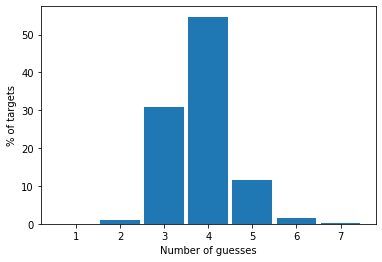

In [39]:
%time show_metric(neg_entropy, True, sgb_words)

That's pretty good. The Wordle web site challenges you to solve each puzzle in six guesses; this guesser can do that almost all the time (the output says "`≤6:100%`" but that's rounded off; it is actually only 99.8%).

# Wordle Words and Wordle Helper

Wordle does not use `sgb-words.txt`, so the results above are good for comparing Jotto to Wordle, but imperfect for actually playing Wordle. I made an attempt to extract the official word list from the [Wordle site](https://www.powerlanguage.co.uk/wordle/). The javascript code there actually contains two word lists, but the code is obfuscated so I'm not sure what's going on with them. Possibly the target word is chosen from the smaller list, and the larger list defines the allowable guesses. Here are the two files:

In [40]:
wordle1 = open('wordle1.txt').read().split()
wordle2 = open('wordle2.txt').read().split()

!wc -w wordle*.txt

    2315 wordle1.txt
   10657 wordle2.txt
   12972 total


Twice as many words as `sgb-words.txt`.

Here's a function, `helper`, to interactively make suggestions for the day's puzzle. First I'll search for top-scoring first guesses:

In [71]:
first_guesses = sorted(wordle1, key=lambda g: neg_entropy(partition_counts(g, wordle1)))
' '.join(first_guesses[:50])

'raise slate crate irate trace arise stare snare arose least alert crane stale saner alter later react leant trade learn cater roast aisle trice scare parse saute heart alone store alien share grate trail siren snore caste scale atone renal'

In [68]:
def helper(words=wordle1 + wordle2, n=15) -> str:
    """Type your guess into Wordle, then type the guess and reply here and get suggestions for the next guess."""
    print(helper.__doc__)
    good = first_guesses[:n]
    while len(words) > 1:
        print(f'{len(words)} possible words. Some good ones:\n{" ".join(good[:n])}.')
        response = input(f'your guess and reply (e.g. "{good[0]} G...Y")?').split()
        guess, reply = response[0].lower(), response[1].upper()
        words = [w for w in words if wordle_reply_for(guess, w) == reply]
        good = sorted(words, key=lambda g: neg_entropy(partition_counts(g, words))) 
    print('It must be:', words[0])

# Next Steps

There are many directions you could take this if you are interested:
- Do the refactoring so that the code can neatly handle multiple different games with different replies, etc.
- Run the computations to figure out the best strategy for Wordle.
- Rerun the computations with the larger Wordle word lists. If necessary, optimize code first.
- Consider game variant where each reply consists of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position (as in Mastermind).
- Implement Mastermind with 6 colors and 4 pegs, and with other combinations.
- What's the best strategy for a chooser who is trying to make the guesser get a bad score.  Is there a strategy equilibrium?
- Our `make_tree` function is **greedy** in that it guesses the word that minimizes some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**? Perhaps with a beam search?
- Can you improve a tree by editing it? Given a tree, look for interior nodes that end up with a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words). Correcting a few bad nodes might be faster than carefully searching for good nodes in the first place.
- Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
- What else can you explore?